### Final EWMACD Method

In [508]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# safe imports
import sys                      # arcgis comes with these
import shutil                   # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
import tempfile                 # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    import osr
    import json
    from scipy.signal import savgol_filter
    from odc import stac
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise # return

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise
    
# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)
    
# grab parameter values 
in_feat = r"C:\Users\Lewis\Desktop\nrt_projects\ophthalmia\monitoring_areas.gdb\monitoring_areas"
in_ongoing = False
in_time_interval = 24
#in_email_from = parameters[3].value                # email from 
#in_smtp_server = parameters[4].value               # email smtp server 
#in_smtp_port = parameters[5].value                 # email smtp port 
#in_smtp_username = parameters[6].value             # email smtp username 
#in_smtp_password = parameters[7].value             # email smtp password 


# # # # #
# notify user and set up progress bar
#arcpy.AddMessage('Beginning NRT Monitoring of areas.')
#arcpy.SetProgressor(type='step', 
                    #message='Preparing parameters...',
                    #min_range=0, max_range=20)
        
# set up initial continous monitoring var
continue_monitoring = True

# check if time interval is > 0
#in_time_interval = in_time_interval * 60 * 60
#if in_time_interval <= 0:
    #arcpy.AddError('Time interval must be above 0 hours.')
    #raise


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Preparing parameters...')
#arcpy.SetProgressorPosition(1)

# get path to monitoring areas feature
feat_desc = arcpy.Describe(in_feat)
in_feat = os.path.join(feat_desc.path, feat_desc.name)


# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Validating monitoring areas...')
#arcpy.SetProgressorPosition(2)

# validate monitoring area feature class
if not nrt.validate_monitoring_areas(in_feat):
    arcpy.AddError('Monitoring areas feature is invalid.')
    raise # return

    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area json data...')
#arcpy.SetProgressorPosition(2)
    
# prepare path to expected json file
in_path = os.path.dirname(in_feat)
in_path = os.path.splitext(in_path)[0]
in_path = os.path.dirname(in_path)
#in_data_path = os.path.join(in_path, 'data.json')
    
    
# # # # #
# notify and increment progress bar
#arcpy.SetProgressorLabel('Loading monitoring area features...')
#arcpy.SetProgressorPosition(2)

# set required fields
fields = [
    'area_id', 
    'platform', 
    's_year', 
    'e_year', 
    'index', 
    'persistence', 
    'rule_1_min_conseqs', 
    'rule_1_inc_plateaus', 
    'rule_2_min_zone', 
    'rule_3_num_zones', 
    'ruleset', 
    'alert', 
    'method',
    'alert_direction', 
    'email', 
    'ignore', 
    'color', 
    'global_id', 
    'SHAPE@'
]

# get feature count and data
try:
    #feats = arcpy.da.SearchCursor(in_feat, fields)
    feats = []
    with arcpy.da.SearchCursor(in_feat, fields) as cursor:
        for row in cursor:
            feats.append(row)
except:
    arcpy.AddError('Could not open monitoring areas feature.')
    raise # return

In [510]:
from importlib import reload
reload(nrt)

<module 'nrt' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\nrt.py'>

In [283]:
import matplotlib.pyplot as plt

In [61]:
# todo:
# remove field rule 1 inc plateaus ... ?
# remove field rule 2 bidirection. we do this via alert dir now - DONE
# change rule 2 min stdv to min zone - DONE
# consider a 'negative remover in positive areas' and vice versa. consider during alert?... add as extra alert dirs? - DONE
# append all mon area field info to netcdf attr, check at start of run for change, delete cube if change
# check if ruleset contains rule without a value entered during area creation (fields accepts nulls) - FORCED REQUIRED!

In [62]:
# 'inc_any':      'Incline only (any)', 
# 'dec_any':      'Decline only (any)', 
# 'inc_pos':      'Incline only (+ zones only)', 
# 'dec_neg':      'Decline only (- zones only)', 
# 'both_any':     'Incline or Decline (any)',
# 'both_pos_neg': 'Incline or Decline (+/- zones only)',

In [144]:
# tips
# use higher persistence for dynamic (1) and lower for static (0.5)
# use decline in - or pos in + only for dynamic to avoid new regime shifts triggering alarm
# turn off spikes for dynamic

In [322]:
class MonitoringArea:
    """
    """

    def __init__(self, feat, path):
        
        # feature fields
        self.area_id = feat[0]
        self.platform = feat[1]
        self.s_year = feat[2]
        self.e_year = feat[3]
        self.index = feat[4]
        self.persistence = feat[5]
        self.rule_1_min_conseqs = feat[6]
        self.rule_1_inc_plateaus = feat[7]
        self.rule_2_min_zone = feat[8]
        self.rule_3_num_zones = feat[9]
        self.ruleset = feat[10]
        self.alert = feat[11]
        self.method = feat[12]
        self.alert_direction = feat[13]
        self.email = feat[14]
        self.ignore = feat[15]
        self.color = feat[16]
        self.global_id = feat[17]
        
        # feature geometry
        self.raw_geom = feat[18]
        self.prj_geom = None
        
        # path to project folder
        self.path = path
        
        # xr datasets
        self.ds_old = None
        self.ds_new = None
        self.ds_cmb = None
        self.ds_anl = None

    
    def show_info(self):
        """
        Simple function to print field information to 
        screen.
        """
        
        # print field attributes
        for field in list(vars(self))[:16]:
            print('{}: {}'.format(field, vars(self).get(field)))
            
        return

    
    def validate_area(self):
        """
        Checks all required monitoring area parameters are 
        valid. Raises an error if invalid.
        """
        
        # check area id
        if self.area_id is None:
            raise ValueError('No area id exists.')

        # check platform
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not Landsat or Sentinel.')

        # check start, end years
        if not isinstance(self.s_year, int):
            raise ValueError('Start year not an integer.')
        elif not isinstance(self.e_year, int):
            raise ValueError('End year not an integer.')
        elif self.s_year < 1980 or self.s_year > 2050:
            raise ValueError('Start year not between 1980-2050.')        
        elif self.e_year < 1980 or self.e_year > 2050:
            raise ValueError('End year not between 1980-2050.')          
        elif self.e_year <= self.s_year:
            raise ValueError('End year is <= start year.')           
        elif abs(self.e_year - self.s_year) < 2:
            raise ValueError('Training period < 2 years in length.')  
        elif self.platform == 'Sentinel' and self.s_year < 2016:
            raise ValueError('Start year must be >= 2016 for Sentinel data.')  

        # check index
        if self.index not in ['NDVI', 'MAVI', 'kNDVI']:
            raise ValueError('Index must be NDVI, MAVI or kNDVI.')

        # check persistence
        if self.persistence is None:
            raise ValueError('No persistence exists.')
        elif self.persistence < 0.001 or self.persistence > 9.999:
            raise ValueError('Persistence not between 0.0001 and 9.999.')

        # check rule 1 min consequtives
        if self.rule_1_min_conseqs is None:
            raise ValueError('No rule 1 min conseqs exists.')
        elif self.rule_1_min_conseqs < 0 or self.rule_1_min_conseqs > 999:
            raise ValueError('Rule 1 min conseqs not between 0 and 999.')

        # check rule 1 inc plateaus
        if self.rule_1_inc_plateaus is None:
            raise ValueError('No rule 1 inc plateaus exists.')
        elif self.rule_1_inc_plateaus not in ['Yes', 'No']:
            raise ValueError('Rule 1 inc plateaus must be Yes or No.')

        # check rule 2 min zone
        if self.rule_2_min_zone is None:
            raise ValueError('No rule 2 min zone exists.')
        elif self.rule_2_min_zone < 1 or self.rule_2_min_zone > 11:
            raise ValueError('Rule 2 min zone not between 1 and 11.') 
            
        # check rule 3 num zones
        if self.rule_3_num_zones is None:
            raise ValueError('No rule 3 num zones exists.')
        elif self.rule_3_num_zones < 1 or self.rule_3_num_zones > 11:
            raise ValueError('rule 3 num zones not between 1 and 11.')             

        # set up allowed rulesets
        rulesets = [
            '1 only',
            '2 only',
            '3 only',
            '1 and 2',
            '1 and 3',
            '2 and 3',
            '1 or 2',
            '1 or 3',
            '2 or 3',
            '1 and 2 and 3',
            '1 or 2 and 3',
            '1 and 2 or 3',
            '1 or 2 or 3'
        ]
        
        # check ruleset   
        if self.ruleset not in rulesets:
            raise ValueError('Rulset not supported.')

        # check alert
        if self.alert not in ['Yes', 'No']:
            raise ValueError('Alert must be Yes or No.')

        # check method
        if self.method not in ['Static', 'Dynamic']:
            raise ValueError('Method must be Static or Dynamic')

        # set up alert directions 
        alert_directions = [
            'Incline only (any)', 
            'Decline only (any)', 
            'Incline only (+ zones only)', 
            'Decline only (- zones only)', 
            'Incline or Decline (any)',
            'Incline or Decline (+/- zones only)'
        ]

        # check alert direction
        if self.alert_direction not in alert_directions:
            raise ValueError('Alert direction is not supported.')

        # check email address
        if self.alert == 'Yes' and self.email is None:
            raise ValueError('No email provided.')
        elif self.email is not None and '@' not in self.email:
            raise ValueError('Email address invalid.')

        # check ignore
        if self.ignore not in ['Yes', 'No']:
            raise ValueError('Ignore must be Yes or No.')
            
        # check global id
        if self.global_id is None:
            raise ValueError('No global id exists.')
            
        # check path provided
        if self.path is None:
            raise ValueError('No project path exists.')

        return
        
        
    def set_old_xr(self):
        """
        If a path exists for old xr, load and set it. 
        If old xr does not exist (i.e., first time area
        has been monitored, set None. If error during load, 
        set old xr to None.
        """
        
        try:
            # build expected netcdf filepath
            nc_path = os.path.join(self.path, self.global_id + '.nc')
        
            # check input path and store if so, else none
            if os.path.exists(nc_path):
                with xr.open_dataset(nc_path) as ds:
                    ds.load()
                
                # set old ds
                self.ds_old = ds
                return
            
            else:
                # set to none
                self.ds_old = None
                return
        
        except:
            self.ds_old = None
            return
        
        return
            
    
    def validate_old_xr(self):
        """
        If old xr is loaded and set, validates it to ensure 
        it has attributes that match current area feature. 
        Done to ensure user has not changed area field values
        since last run. If old xr attributes and current area 
        do not match, set old xr dataset to None (i.e., reset
        it).
        """
        
        # if old xr doesnt exist, leave
        if self.ds_old is None:
            return
            
        # check xr is valid
        if not isinstance(self.ds_old, xr.Dataset):
            self.ds_old = None
            return
        elif not hasattr(self.ds_old, 'attrs'):
            self.ds_old = None
            return

        try:
            # check key attrs in dataset
            attrs = list(vars(self))[:16]
            for attr in attrs:
                if not hasattr(self.ds_old, attr):
                    self.ds_old = None
                    return

            # check all vals match match (remove tail, add method back on)
            attrs = attrs[:11] + ['method']
            for attr in attrs:
                new = str(vars(self).get(attr))
                old = str(self.ds_old.attrs.get(attr))

                if new != old:
                    self.ds_old = None
                    return
                    
        except:
            self.ds_old = None
            return
        
        return
            
    
    # TODO SET END DATE TO 2050 WHEN DONE
    def set_new_xr(self):
        """
        Fetches all available digital earth australia (dea) 
        landsat/sentinel data for area bounding box. The 
        resulting data is set to the new xr. If old xr 
        exists (is not None), new xr is then subset down to 
        only the dates that dont exist in old xr. 
        
        If an error occurs, an error is raised. 
        """
        
        # set endpoint
        STAC_ENDPOINT = 'https://explorer.sandbox.dea.ga.gov.au/stac'
        
        # check platform is valid
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not supported.')

        # prepare dea stac search parameters
        if self.platform == 'Landsat':
            
            # set dea collection names
            collections = [
                'ga_ls5t_ard_3',
                'ga_ls7e_ard_3',
                'ga_ls8c_ard_3',
                'ga_ls8c_ard_provisional_3'
            ]
            
            # set bands
            bands = [
                'nbart_red', 
                'nbart_green', 
                'nbart_blue', 
                'nbart_nir', 
                'nbart_swir_1', 
                'nbart_swir_2', 
                'oa_fmask'
            ]
            
        elif self.platform == 'Sentinel':
            
            # set dea collection names
            collections = [
                's2a_ard_granule',  # todo: use ver 3 when avail
                's2b_ard_granule',  # todo: use ver 3 when avail
                'ga_s2am_ard_provisional_3',
                'ga_s2bm_ard_provisional_3'
            ]
            
            # set bands
            bands = [
                'nbart_red', 
                'nbart_green', 
                'nbart_blue', 
                'nbart_nir_1', 
                'nbart_swir_2', 
                'nbart_swir_3', 
                'fmask'
            ]
        
        
        try:
            # ensure raw geom is in wgs84 (set prj_geom)
            srs = arcpy.SpatialReference(4326)
            self.prj_geom = self.raw_geom.projectAs(srs)
            
            # convert to bounding box in wgs84
            prj_bbox = [
                self.prj_geom.extent.XMin,
                self.prj_geom.extent.YMin,
                self.prj_geom.extent.XMax,
                self.prj_geom.extent.YMax
            ]
        
        except Exception as e:
            raise ValueError(e)
            
            
        try:
            # get all avail dea satellite data without compute
            self.ds_new = nrt.fetch_cube_data(collections=collections, 
                                              bands=bands, 
                                              start_dt='1980-01-01', 
                                              end_dt='2016-12-31', 
                                              bbox=prj_bbox, 
                                              resolution=10, 
                                              ds_existing=None)
        
            # group duplicate times if exist
            self.ds_new = satfetcher.group_dupe_times(self.ds_new)
            
        except Exception as e:
            raise ValueError(e)
            
            
        try:
            # subset new xr to new dates (if old exists)
            if self.ds_old is not None:
                
                # get last datetime in old dataset
                last_dt = self.ds_old['time'].isel(time=-1)
                
                # get all datetimes in new dataset
                new_dts = self.ds_new['time']
                new_dts = new_dts.where(new_dts['time'] > last_dt, drop=True)
                
                # select only new
                self.ds_new = self.ds_new.sel(time=new_dts)       
                
            # enforce none type if no new dates
            if len(self.ds_new['time']) == 0:
                self.ds_new = None
                
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def new_xr_dates_found(self):
        """
        Does quick check to see if any new xr dates currently 
        exist. Returns true if times exist, false if not.
        """
        
        # check if dates exist
        if self.ds_new is None:
            return False
        elif 'time' not in self.ds_new:
            return False
        elif len(self.ds_new['time']) == 0:
            return False
        else:
            return True
        
        return
        
        
    def count_new_xr_dates(self):
        """
        Get number of dates in new xr.
        """
        
        # count based on time dim
        if self.ds_new is not None:
            return len(self.ds_new['time'])
        
        return
    
    
    def apply_new_xr_fmask(self):
        """
        Takes the new xr and applies the dea fmask band to 
        remove invalid pixels and dates. If an error occurs,
        error is raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        
        try:
            # get mask band name (either be oa_fmask or fmask)
            mask = [v for v in self.ds_new if 'mask' in v][0]
            
            # mask invalid pixels i.e., not valid, water, snow
            self.ds_new = cog.remove_fmask_dates(ds=self.ds_new, 
                                                 valid_class=[1, 4, 5],
                                                 max_invalid=0,
                                                 mask_band=mask, 
                                                 nodata_value=np.nan,
                                                 drop_fmask=True)
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def apply_new_xr_index(self):
        """
        Takes the new xr and applies user chosen vegetation
        index. If an error occurs, error is raised. 
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        
        # check if platform set
        if self.platform not in ['Landsat', 'Sentinel']:
            raise ValueError('Platform not supported.')
            
        # check if index set
        if self.index not in ['NDVI', 'MAVI', 'kNDVI']:
            raise ValueError('Index not supported.')
        
        try:
            # conform dea band names and calc vegetation index
            platform = self.platform.lower()
            self.ds_new = satfetcher.conform_dea_ard_band_names(ds=self.ds_new, 
                                                                platform=platform) 
            
            # calculate vegetation index
            index = self.index.lower()
            self.ds_new = tools.calculate_indices(ds=self.ds_new, 
                                                  index=index, 
                                                  custom_name='veg_idx', 
                                                  rescale=False, 
                                                  drop=True)
        except Exception as e:
            raise ValueError(e)
            
        return
            
            
    def load_new_xr(self):
        """
        Loads new xr values into memory using the xarray 
        load function. This will result in downloading from 
        dea and can take awhile.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        
        try:
            # load new xr and close connection 
            self.ds_new.load()
            self.ds_new.close()
        
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def remove_new_xr_edges(self):
        """
        Sets any pixels in the new xr to nodata (nan) if they occur 
        within the original bounding box but outside of the vector
        boundary of the monitoring area. This is achieved by creating 
        an in-memory raster of 1s and 0s (in boundary, out boundary) 
        and applies it to the new dataset. If an error occurs,
        no mask is applied.
        """ 
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
            
        # check if raw geometry exists
        if self.raw_geom is None:
            raise ValueError('No raw area geometry provided.')       
        
        try:
            # take a copy in case of error
            tmp = self.ds_new.copy(deep=True)
            
            # rasterize area polygon, set outside pixels to nan
            mask = nrt.rasterize_polygon(ds=self.ds_new, 
                                         geom=self.raw_geom)
            
            # mask edge pixels to nan
            self.ds_new = self.ds_new.where(mask)
            
            # check if not all nan
            if self.ds_new.to_array().isnull().all():
                raise ValueError('Mask set all pixels to nan, rolling back.')  

        except Exception as e:
            self.ds_new = tmp
            raise ValueError(e)
            
        return
            

    def reduce_new_xr(self):
        """
        Reduces new xr dataset into temporal medians. That is, one 
        median vegetation index value for the entire monitoring area 
        per date. If an error occurs, error is raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')        
        
        try:
            # get temporal medians
            self.ds_new = self.ds_new.median(['x', 'y'])
        
        except Exception as e:
            raise ValueError(e)
            
        return
    
    
    def interp_new_xr_nans(self):
        """
        Interpolates any existing nan values in new xr linearly.
        If nan values still exist after interpolation (often on
        edge dates due to lack of extrapolation), these will be
        dropped. If error occurs or all values are nan, error is
        raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')          

        try:
            # interpolate na linearly
            self.ds_new = self.ds_new.interpolate_na('time')
            
            # check if any nan
            if self.ds_new.to_array().isnull().any():
                self.ds_new = self.ds_new.where(~self.ds_new.isnull(), 
                                                drop=True)
        except Exception as e:
            raise ValueError(e)
            
        # check we have data remaining
        if len(self.ds_new['time']) == 0:
            raise ValueError('No data remaining after nodata dropped.')
            
        return


    def append_new_xr_vars(self):
        """
        Appends required xr variables to new xr if do not exist.
        These variables are required for storing outputs from 
        change detection results, cleaned vegetation, etc. If
        error, error is raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')  
        
        # set required variable names
        new_vars = [
            'veg_clean', 
            'static_raw', 
            'static_clean',
            'static_rule_one',
            'static_rule_two',
            'static_rule_three',
            'static_zones',
            'static_alerts',
            'dynamic_raw', 
            'dynamic_clean',
            'dynamic_rule_one',
            'dynamic_rule_two',
            'dynamic_rule_three',
            'dynamic_zones',
            'dynamic_alerts'
        ]        
        
        # iter var names and append to xr
        for var in new_vars:
            if var not in self.ds_new:
                da = xr.full_like(self.ds_new['veg_idx'], np.nan)
                self.ds_new[var] = da
        
        return
        
            
    def set_cmb_xr(self):
        """
        Takes old xr (if exists) and concatenates the new 
        xr dates and values onto the end of the old xr (if
        exists). A single cmb (combined) xr is created as
        a result. This is done to ensure old xr change and
        vegetation values persist from one monitoring
        cycle to another. If no old xr exists, new xr is
        set to as cmb xr. If error, error raised.
        """
        
        # check if new xr exists
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
            
        # set new xr to cmb xr if no old xr
        if self.ds_old is None:
            self.ds_cmb = self.ds_new.copy(deep=True)
            return
        
        try:
            # add new times onto end of old times
            xrs = [self.ds_old, self.ds_new]
            self.ds_cmb = xr.concat(xrs, dim='time')
            
            # sort by time
            self.ds_cmb = self.ds_cmb.sortby('time')
        
        except Exception as e:
            raise ValueError(e)
            
        return

    
    def fix_cmb_xr_spikes(self):
        """
        Detects severe vegetation index outliers using the TIMESAT 
        3.3 median spike detection method. Sets spike values to 
        nan and then interpolates them, if they exist. If error, error raised.
        """
        
        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
        
        try:
            # remove outliers via median spike method
            da = nrt.remove_spikes(da=self.ds_cmb['veg_idx'], 
                                   factor=1, 
                                   win_size=3)
            
            # interpolate nans linearly
            da = da.interpolate_na('time')
            
            # set result to clean var
            self.ds_cmb['veg_clean'] = da            
            
            # if nans still exists, drop them in cmb xr
            if da.isnull().any():
                self.ds_cmb = self.ds_cmb.where(~da.isnull(), drop=True)
        
        except Exception as e:
            raise ValueError(e)
            
        # check we still have data remaining
        if len(self.ds_cmb['time']) == 0:
            raise ValueError('No data remaining after no data dropped.')
            
        return

        
    def smooth_cmb_xr_index(self):
        """
        Mildly smoothes the cmb xr clean vegetation index values 
        using the savitsky golay filter. If error, error raised.
        """

        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
        
        try:
            # get time dimension axis
            dims = list(self.ds_cmb.dims)
            for idx, dim in enumerate(dims):
                if dim == 'time':
                    axis = idx

            # set up kwargs
            kwargs={
                'window_length': 3, 
                'polyorder': 1,
                'axis': axis
            }

            # apply savitsky filter to outlier-free index
            da = xr.apply_ufunc(savgol_filter, 
                                self.ds_cmb['veg_clean'],
                                dask='allowed',
                                kwargs=kwargs)
                
            # update existing values in cmb xr
            self.ds_cmb['veg_clean'] = da
        
        except Exception as e:
            raise ValueError(e)
            
        return
    

    def set_anl_xr(self):
        """
        Takes cmb xr (if exists) and copys it in memory. The
        copied xr dataset is then subset to the training start 
        year (all years before are removed). The result is the anl 
        (analysis) xr, which is exists to be used temporarily to 
        generate new change models. If error, error raised.
        """
        
        # check if start year is valid
        if self.s_year is None:
            raise ValueError('Not training start year provided.')

        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')
            
        try:
            # copy cmb xr to anl xr
            self.ds_anl = self.ds_cmb.copy(deep=True)
            
            # remove all dates before start year
            dts = self.ds_anl['time.year'] >= self.s_year
            self.ds_anl = self.ds_anl.where(dts, drop=True)
                    
        except Exception as e:
            raise ValueError(e)
            
        # check if dates valid
        if len(self.ds_anl) == 0:
            raise ValueError('No dates remaning in dataset.')
        elif len(area.ds_cmb.groupby('time.year')) < 3:
            raise ValueError('Not enough years remaining in dataset.')
        
        return
        

    # TODO play with smoothing, persistence
    def detect_change_anl_xr(self):
        """
        Performs ewmacd change detection (static and dynamic 
        types) on anl xr. Uses the raw vegetation index time
        series to detect the change. If error or all nan, error 
        raised.
        """

        # check if anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
            
        # check start and end years valid
        if self.s_year is None or self.e_year is None:
            raise ValueError('No start and/or end year provided.')        
            
        # check if persistence is valid
        if self.persistence is None:
            raise ValueError('No persistence provided.')
            
        try:
            # perform ewmacd change detection
            self.ds_anl = nrt.detect_change(ds=self.ds_anl,
                                            method='both',
                                            var='veg_idx',
                                            train_start=self.s_year,
                                            train_end=self.e_year,
                                            persistence=self.persistence)
        except Exception as e:
            raise ValueError(e)
            
        # check if we have data
        for var in ['static_raw', 'dynamic_raw']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Change result is empty.')            
            
        return
        
          
    def smooth_anl_xr_change(self):
        """
        Mildly smoothes the anl xr static and dynamic change 
        signal values using the savitsky golay filter. If error, 
        error raised.
        """

        # check if anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')

        try:
            # get time dimension axis
            dims = list(self.ds_anl.dims)
            for idx, dim in enumerate(dims):
                if dim == 'time':
                    axis = idx

            # set up kwargs
            kwargs={
                'window_length': 3, 
                'polyorder': 1,
                'axis': axis
            }

            # apply savitsky filter to static change values
            da_static = xr.apply_ufunc(savgol_filter, 
                                       self.ds_anl['static_raw'],
                                       dask='allowed',
                                       kwargs=kwargs)

            # apply savitsky filter to dynamic change values
            da_dynamic = xr.apply_ufunc(savgol_filter, 
                                        self.ds_anl['dynamic_raw'],
                                        dask='allowed',
                                        kwargs=kwargs)

            # update static and dynamic clean values in anl xr
            self.ds_anl['static_clean'] = da_static
            self.ds_anl['dynamic_clean'] = da_dynamic

        except Exception as e:
            raise ValueError(e)

        return       


    def transfer_old_to_anl_xr(self):
        """
        Takes old xr and transfers all historical values
        (i.e., everything except new values) to the anl xr
        (which contains everything from training period 
        onwards.) This is done to ensure fluctuations in 
        prior change values persists up until the newest 
        values. If an error occurs, error raised.
        """
        
        # if no old xr, skip transfer
        if self.ds_old is None:
            return
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
            
        # set up relevant vars
        data_vars = [
            'static_raw', 
            'static_clean', 
            'dynamic_raw', 
            'dynamic_clean'
        ]
        
        # ensure vars exist in both xrs
        for var in data_vars:
            if var not in self.ds_old or var not in self.ds_anl:
                raise ValueError('Missing variables in old and/or new xrs.')
        
        try:         
            # transfer vals from old to anl xr at matching dates
            self.ds_anl = nrt.transfer_xr_values(ds_to=self.ds_anl,
                                                 ds_from=self.ds_old,
                                                 data_vars=data_vars)
        except Exception as e:
            raise ValueError(e)
            
        return

            
    def build_zones(self):
        """
        Takes cleaned static and dynamic change deviation
        values and classifies them into 1 of 11 zones based
        on where the change value falls. Honours direction 
        of change by returning zone value with sign (+/-).
        If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
                    
        try:
            # build zone values using smoothed static signal
            da = self.ds_anl['static_clean']
            self.ds_anl['static_zones'] = xr.apply_ufunc(nrt.build_zones, da)

            # build zone values using smoothed dynamic signal
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_zones'] = xr.apply_ufunc(nrt.build_zones, da)
        
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_zones', 'dynamic_zones']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Zone result is empty.')
            
        return
            
    
    def build_rule_one(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule one rules to them. Rule one
        calculates consequtive runs of values across time.
        Honours direction of change by returning value 
        with sign (+/-). If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule one parameters valid
        if self.rule_1_min_conseqs is None:
            raise ValueError('No minimum consequtives provided.')
        elif self.rule_1_inc_plateaus is None:
            raise ValueError('No include plateaus provided.')   
            
        # prepare plateaus
        if self.rule_1_inc_plateaus == 'Yes':
            plateaus = True
        else:
            plateaus = False
            
        # set kwarg options
        kwargs = {
            'min_conseqs': self.rule_1_min_conseqs,
            'inc_plateaus': plateaus
        }

        try:
            # generate all rule 1 runs (+/-) for static change
            da = self.ds_anl['static_clean']
            self.ds_anl['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                            da,
                                                            kwargs=kwargs)

            # generate all rule 1 runs (+/-) for dynamic change
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                             da,
                                                             kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)

        # check if we have any data
        for var in ['static_rule_one', 'dynamic_rule_one']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Rule one result empty.')
            
        return
            
            
    def build_rule_two(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule two rules to them. Rule two
        masks out stdv values that fall within a specified
        minimum zone threshold. Honours direction of change 
        by returning value with sign (+/-). If error occurs, 
        error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule two parameters valid
        if self.rule_2_min_zone is None:
            raise ValueError('No minimum zone provided.')
            
        # convert zone to std
        stdvs = nrt.zone_to_std(self.rule_2_min_zone)[0]
         
        # set kwarg options
        kwargs = {'min_stdv': stdvs}

        try:
            # generate all rule 2 mask (+/-) for static change
            da = self.ds_anl['static_clean']
            self.ds_anl['static_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                            da,
                                                            kwargs=kwargs)

            # generate all rule 2 mask (+/-) for dynamic change
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                             da,
                                                             kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_rule_two', 'dynamic_rule_two']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Rule two result empty.')
            
        return
            
            
    def build_rule_three(self):
        """
        Takes cleaned static and dynamic change deviation
        values and applies rule three rules to them. Rule three
        detects sharp zone value spikes that occurr between 
        dates. Honours direction of change by returning value 
        with sign (+/-). If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # check if required vars in xr
        if 'static_clean' not in self.ds_anl:
            raise ValueError('No clean static variable.')
        elif 'dynamic_clean' not in self.ds_anl:
            raise ValueError('No clean dynamic variable.')
        
        # check if rule three parameters valid
        if self.rule_3_num_zones is None:
            raise ValueError('No number of zones provided.')
            
        # convert zone to std and multiple by 2 (2 std per zone)
        stdvs = nrt.zone_to_std(self.rule_3_num_zones)[0] 
        stdvs = stdvs * 2
        
        # set kwarg options
        kwargs = {'min_stdv': stdvs}

        try:
            # generate all rule 3 spikes (+/-) for static change
            da = self.ds_anl['static_clean']
            self.ds_anl['static_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                              da,
                                                              kwargs=kwargs)

            # generate all rule 3 spikes (+/-) for dynamic change
            da = self.ds_anl['dynamic_clean']
            self.ds_anl['dynamic_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                               da,
                                                               kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)    
            
        # check if we have any data
        for var in ['static_rule_three', 'dynamic_rule_three']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Rule two result empty.')
                
        return

                
    def build_alerts(self):
        """
        Takes the previously derived rule one, two, three values
        and combines them into an alert mask (1, 0) variable for 
        static and dynamic methods. This method considers 
        both the user's requested ruleset and the particular
        direction of change (incline or decline) required for
        alert to be set as true (1). If error occurs, error raised.
        """
        
        # check if old and anl xr exists
        if self.ds_anl is None:
            raise ValueError('No anl xr provided.')
        
        # set up valid rulesets
        valid_rules = [
            '1 only', 
            '2 only', 
            '3 only', 
            '1 and 2', 
            '1 and 3', 
            '2 and 3', 
            '1 or 2', 
            '1 or 3', 
            '2 or 3', 
            '1 and 2 and 3', 
            '1 or 2 and 3',
            '1 and 2 or 3', 
            '1 or 2 or 3'
        ]
        
        # check if ruleset valid
        if self.ruleset not in valid_rules:
            raise ValueError('Ruleset not supported.')
        
        # set up valid directions 
        valid_directions = [
            'Incline only (any)',
            'Decline only (any)',
            'Incline only (+ zones only)',
            'Decline only (- zones only)',
            'Incline or Decline (any)',
            'Incline or Decline (+/- zones only)'
        ]
        
        # check if direction valid
        if self.ruleset not in valid_rules:
            raise ValueError('Direction not supported.')
        
        # set kwarg options
        kwargs = {
            'ruleset': self.ruleset,
            'direction': self.alert_direction
        }

        try:
            # generate and combines rules into alert for static change 
            self.ds_anl['static_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                          self.ds_anl['static_rule_one'],
                                                          self.ds_anl['static_rule_two'],
                                                          self.ds_anl['static_rule_three'],
                                                          #vectorize=True,
                                                          kwargs=kwargs)

            # generate and combines rules into alert for dynamic change 
            self.ds_anl['dynamic_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                           self.ds_anl['dynamic_rule_one'],
                                                           self.ds_anl['dynamic_rule_two'],
                                                           self.ds_anl['dynamic_rule_three'],
                                                           #vectorize=True,
                                                           kwargs=kwargs)
        except Exception as e:
            raise ValueError(e)
            
        # check if we have any data
        for var in ['static_alerts', 'dynamic_alerts']:
            if self.ds_anl[var].isnull().all():
                raise ValueError('Alert result empty.')
                
        return
    
    
    def transfer_anl_to_cmb_xr(self):
        """
        Takes the anl xr values and transfers to new xr dates
        to ensure we only have the latest analysis results. 
        The new results are then added to the cmb xr to ensure
        the historical values are not touched yet still 
        associated with the newest dates and values. If an error 
        occurs, error raised.
        """
        
        # check if new, anl, cmb xrs valid
        if self.ds_new is None:
            raise ValueError('No new xr provided.')
        elif self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')   
        elif self.ds_anl is None:
            raise ValueError('No anl xr provided.')

        # get relevant change var names in anl xr
        data_vars = []
        for var in self.ds_anl:
            if 'static' in var or 'dynamic' in var:
                data_vars.append(var)

        # check if vars exist
        if len(data_vars) == 0:
            raise ValueError('No required variables exist.')
            
        # check if vars in other xrs
        for var in data_vars:
            if var not in self.ds_new or var not in self.ds_cmb:
                raise ValueError('Required vars not in new or cmb xrs.')
                
        try:
            # transfer vals from anl to new xr at matching dates
            self.ds_new = nrt.transfer_xr_values(ds_to=self.ds_new,
                                                 ds_from=self.ds_anl,
                                                 data_vars=data_vars)
            
            # transfer vals from new to cmb xr at matching dates
            self.ds_cmb = nrt.transfer_xr_values(ds_to=self.ds_cmb,
                                                 ds_from=self.ds_new,
                                                 data_vars=data_vars)
        except Exception as e:
            raise ValueError(e)

        return

    
    def append_cmb_xr_attrs(self):
        """
        Takes the current monitoring area feature's field
        values (i.e., attributes) and updates the cmb xr's
        internal attributes to match. This is done as the
        process strips attributes off the xr due to various
        numpy operations. If error, error raised.
        """
        
        # check if cmb xr exists
        if self.ds_cmb is None:
            raise ValueError('No cmb xr provided.')

        try:
            # iter required attributes and update
            for attr in list(vars(self))[:16]:
                attr = {attr: str(vars(self).get(attr))}
                self.ds_cmb.attrs.update(attr)
        
        except Exception as e:
            raise ValueError(e)
            
        return
        


In [323]:
# create instance of monitoring area and path and display info
area = MonitoringArea(feat, path=in_path)


# # # # #   
arcpy.AddMessage('Starting process for area {}.'.format(area.area_id))

# show information about area
area.show_info()


# # # # # validate area. invalid value triggers error, skip on error    
try:
    # validate area. invalid value triggers error, skip on error
    area.validate_area()
except Exception as e:
    arcpy.AddWarning('Area {} is invalid, see messages.'.format(area.area_id))
    arcpy.AddMessage(str(e))
    raise # continue
    
      
# # # # # get old xr. if no old or error, sets old to none. pass if none or error
try:
    # get old xr. if no old or error, sets old to none. pass if none or error
    area.set_old_xr()
except:
    arcpy.AddWarning('No existing xr for area, getting new xr.')
    pass
    

# # # # # validate old xr. skips old xr if none. changed attrs sets old xr to none
try:
    # validate old xr. skips old xr if none. changed attrs sets old xr to none
    area.validate_old_xr()
except:
    arcpy.AddWarning('Attributes of existing xr have changed, resetting.')
    pass    


# # # # # get all sat data. subset new xr to new dates if old xr exists. on error, set new to none, skip
try:
    # get all sat data. subset new xr to new dates if old xr exists. on error, set new to none, skip
    area.set_new_xr()  
    
    # skip if no new dates, else notify
    if area.new_xr_dates_found() is False:
        arcpy.AddMessage('No new satellite dates found, skipping.')
        raise # continue     
except Exception as e:
    arcpy.AddWarning('Could not obtain satellite data, see messages.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # apply fmask on new xr. if error or no dates, skip
try:
    # apply fmask on new xr. if error or no dates, skip
    area.apply_new_xr_fmask()

    # skip if no new dates, else notify
    if area.new_xr_dates_found() is False:
        arcpy.AddMessage('No cloud free data exists, skipping.')
        raise # continue   
except Exception as e:
    arcpy.AddWarning('Could not apply fmask, see messages.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # apply veg index on new xr. if error or no dates, skip
try:
    # apply veg index on new xr. if error or no dates, skip
    area.apply_new_xr_index() 
except Exception as e:
    arcpy.AddWarning('Could not apply vegetation index, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    

# # # # # load new xr. if error, skip
try:
    # load new xr. if error, skip
    area.load_new_xr() 
except Exception as e:
    arcpy.AddWarning('Could not load satellite data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    

# # # # # remove edge pixels. if error or empty, return orig new xr
try:
    # remove edge pixels. if error or empty, return orig new xr
    area.remove_new_xr_edges() 
except Exception as e:
    arcpy.AddWarning('Could not mask edge pixels, proceeding with them.')
    arcpy.AddMessage(str(e))
    pass
    

# # # # # reduce new xr to median value per date. if error, skip
try:
    # reduce new xr to median value per date. if error, skip
    area.reduce_new_xr() 
except Exception as e:
    arcpy.AddWarning('Could not reduce data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # interp nans. if any remain, drop. if empty, error and skip
try:
    # interp nans. if any remain, drop. if empty, error and skip
    area.interp_new_xr_nans() 
except Exception as e:
    arcpy.AddWarning('Could not interpolate data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # append required vars to new xr. if error, skip
try:
    # append required vars to new xr. if error, skip
    area.append_new_xr_vars() 
except Exception as e:
    arcpy.AddWarning('Could not add vars to data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue

    
# # # # # combine old and new xrs. if no old xr, new xr used. if error, skip
try:
    # combine old and new xrs. if no old xr, new xr used. if error, skip
    area.set_cmb_xr() 
except Exception as e:
    arcpy.AddWarning('Could not combine old and new data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # replaces spikes with interp in cmb xr. set result to veg_clean var. if error or no data, skip
try:
    # replaces spikes with interp in cmb xr. set result to veg_clean var. if error or no data, skip
    area.fix_cmb_xr_spikes() 
except Exception as e:
    arcpy.AddWarning('Could not remove spike outliers, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue

    
# # # # # smooth clean veg index with savitsky filter in cmb xr. if error, skip
try:
    # smooth clean veg index with savitsky filter in cmb xr. if error, skip
    area.smooth_cmb_xr_index() 
except Exception as e:
    arcpy.AddWarning('Could not smooth index, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # create analysis (anl) xr, remove pre-training years. if error, skip
try:
    # create analysis (anl) xr, remove pre-training years. if error, skip
    area.set_anl_xr()
except Exception as e:
    arcpy.AddWarning('Could not create analysis data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    

# # # # # detect raw static, dynamic change via anl xr, if error, skip
try:
    # detect raw static, dynamic change via anl xr, if error, skip
    area.detect_change_anl_xr()
except Exception as e:
    arcpy.AddWarning('Could not perform change detection, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    

# # # # # smooth static, dynamic change via anl xr, if error, skip
try:
    # smooth static, dynamic change via anl xr, if error, skip
    area.smooth_anl_xr_change()
except Exception as e:
    arcpy.AddWarning('Could not smooth change data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    

# # # # # transfer old xr change values to anl xr to persist history. if error, skip
try:
    # transfer old xr change values to anl xr to persist history. if error, skip
    area.transfer_old_to_anl_xr()
except Exception as e:
    arcpy.AddWarning('Could not transfer old data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    

# # # # # build zones. if error, skip
try:
    # build zones. if error, skip
    area.build_zones()
except Exception as e:
    arcpy.AddWarning('Could not generate zones, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue

    
area.rule_2_min_zone = 2  # testing
area.rule_3_num_zones = 2 # testing

# # # # # build rule one, two, three. if error, skip
try:
    # build rule one, two, three. if error, skip
    area.build_rule_one()
    area.build_rule_two()
    area.build_rule_three()
except Exception as e:
    arcpy.AddWarning('Could not generate rules, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue


# # # # # build alerts. if error, skip   
try:
    # build alerts. if error, skip
    area.build_alerts()
except Exception as e:
    arcpy.AddWarning('Could not generate alerts, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue

    
# # # # # transfer anl xr to cmb xr to persist history. if error, skip
try:
    # transfer anl xr to cmb xr to persist history. if error, skip
    area.transfer_anl_to_cmb_xr()
except Exception as e:
    arcpy.AddWarning('Could not transfer analysis data, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue
    
    
# # # # # append area field attrs back on to cmb xr. if error, skip
try:
    # append area field attrs back on to cmb xr. if error, skip
    area.append_cmb_xr_attrs()
except Exception as e:
    arcpy.AddWarning('Could not append attributes, see messages. Skipping.')
    arcpy.AddMessage(str(e))
    raise # continue    
    
    
# # # # # send alert if requested. if error, skip

    
    
# exoort cmb
# next area

area_id: A1
platform: Landsat
s_year: 2000
e_year: 2005
index: MAVI
persistence: 1.0
rule_1_min_conseqs: 3
rule_1_inc_plateaus: No
rule_2_min_zone: 1
rule_3_num_zones: 2
ruleset: 1 and 2 or 3
alert: No
method: Static
alert_direction: Decline only (any)
email: None
ignore: No
Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 1030 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
Removing dates where too many invalid pixels.
Mask band is currently dask. Computing, please wait.
Filling invalid pixels with requested nodata value.
Dropping mask band.
Removed invalid images successfully.
Conforming 

In [327]:
area.show_info()

area_id: A1
platform: Landsat
s_year: 2000
e_year: 2005
index: MAVI
persistence: 1.0
rule_1_min_conseqs: 3
rule_1_inc_plateaus: No
rule_2_min_zone: 2
rule_3_num_zones: 2
ruleset: 1 and 2 or 3
alert: No
method: Static
alert_direction: Decline only (any)
email: None
ignore: No


In [326]:
area.ds_cmb

<xarray.Dataset>
Dimensions:             (time: 444)
Coordinates:
    spatial_ref         int32 3577
  * time                (time) datetime64[ns] 1986-08-18T01:18:25 ... 2016-12...
Data variables: (12/16)
    veg_idx             (time) float32 0.4365 0.3947 0.3571 ... 0.2325 0.2362
    veg_clean           (time) float32 0.4358 0.3961 0.3707 ... 0.2313 0.2368
    static_raw          (time) float32 nan nan nan nan ... -5.0 -5.0 -5.0 -5.0
    static_clean        (time) float32 nan nan nan nan ... -5.0 -5.0 -5.0 -5.0
    static_rule_one     (time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    static_rule_two     (time) float32 nan nan nan nan ... -5.0 -5.0 -5.0 -5.0
    ...                  ...
    dynamic_clean       (time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    dynamic_rule_one    (time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    dynamic_rule_two    (time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    dynamic_rule_three  (time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    dynamic_zones       (time) float32 nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    dynamic_alerts      (time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes: (12/16)
    area_id:              A1
    platform:             Landsat
    s_year:               2000
    e_year:               2005
    index:                MAVI
    persistence:          1.0
    ...                   ...
    ruleset:              1 and 2 or 3
    alert:                No
    method:               Static
    alert_direction:      Decline only (any)
    email:                None
    ignore:               No

In [385]:
#def send_alert():
#"""
#"""

# check if cmb xr exists
if area.ds_cmb is None:
    raise ValueError('No cmb xr provided.')
    
# check if alert parameters valid
if area.alert not in ['Yes', 'No']:
    raise ValueError('Alert type not supported.')
elif area.method not in ['Static', 'Dynamic']:
    raise ValueError('Alert method not supported.')
    
try:
    # get the second latest date as new object
    pix = area.ds_cmb.isel(time=-2).copy(deep=True)   
    
    # remove all vars with method name, strip method from var
    method = area.method.lower()
    pix = pix.drop_vars([var for var in pix if method not in var])
    for var in pix:
        new_var = var.replace(method + '_', '')
        pix = pix.rename({var: new_var})
    
    # get flag and color values
    flag = True if pix['alerts'] == 1 else False
    color = int(pix['zones'])

except Exception as e:
    raise ValueError(e)
    
try:
    # get gdb featureclass path
    fc_path = os.path.join(area.path, 'monitoring_areas.gdb')
    
    # if featureclass exists, update color
    if os.path.exists(fc_path):
        fc = os.path.join(fc_path, 'monitoring_areas')
        fields = ['area_id', 'color']
        
        with arcpy.da.UpdateCursor(fc, fields) as cursor:
            for row in cursor:
                if row[0] == area.area_id:
                    row[1] = color
                    cursor.updateRow(row)
                    break
                
    # remove, add back to active map
    # todo
    
    
except Exception as e:
    raise ValueError(e)

In [386]:
fc_path

'C:\\Users\\Lewis\\Desktop\\nrt_projects\\ophthalmia\\monitoring_areas.gdb'

In [342]:

    


               
except Exception as e:
    raise ValueError(e)
    
try:
    # now, send email if requested
    if self.alert == 'Yes':
        if self.email not None:
            print('todo')
            
except Exception as e:
    raise ValueError(e)            


'C:\\Users\\Lewis\\Desktop\\nrt_projects\\ophthalmia\\monitoring_areas.gdb\\monitoring_areas'

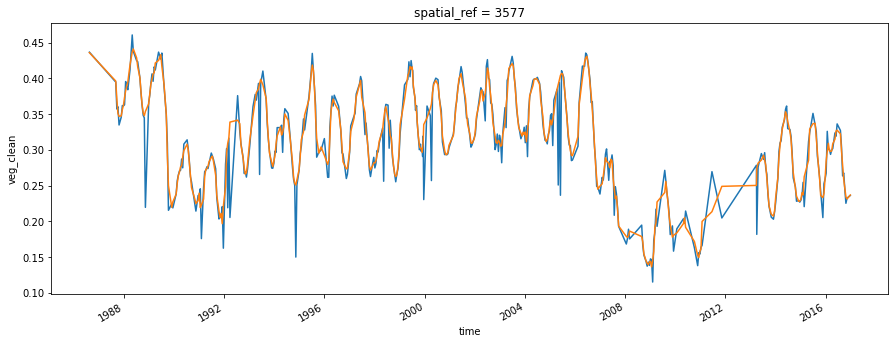

In [345]:
%matplotlib inline

fig = plt.figure(figsize=[15, 5])

area.ds_cmb['veg_idx'].plot()
area.ds_cmb['veg_clean'].plot()
plt.show()

In [27]:




# generate zones
area.build_zones()

# generate rule one  
#area.rule_1... = 2 #TESTING
area.build_rule_two()

# generate rule two
area.rule_2_min_zone = 2 # TESTING
area.build_rule_two()

# generate rule three
area.rule_3_num_zones = 2 # TESTING
area.build_rule_three()

# generate alerts
area.build_alerts()

# get second last pixel and send email
#


# transfer tmp on to cmb
area.transfer_tmp_to_cmb_xr()


# append attributes on to xr
area.append_xr_site_attrs()



# fpr testing: remove everything < 2016-01-01 before export

# export cube

# before new cycle, set all datasets to none
# wait...

Obtaining all satellite data for monitoring area.
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
Searching collection: ga_ls8c_ard_provisional_3
A total of 1030 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
Removing dates where too many invalid pixels.
Mask band is currently dask. Computing, please wait.
Filling invalid pixels with requested nodata value.
Dropping mask band.
Removed invalid images successfully.
Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.
Calculating indices: mavi.
Calculating index: mavi
Renamed default indices.
Calculated indices successfully.
Removing spike outliers.
Spike removal completed successfully.
Beginning change detection.


ValueError: object of type 'float' has no len()

In [11]:
# # # # #
# notify and set progress bar to defaukt
#arcpy.SetProgressor(type='default', 
                    #message='Iterating through monitoring areas...')

# begin monitoring process iteration
while continue_monitoring:
    for feat in feats:
        
        raise
        
        # # # # #
        # notify and set progress bar to defaukt
        arcpy.AddMessage('Setting up monitoring for area: {}...'.format(feat[0]))

        # check if current feat is valid
        if not nrt.validate_monitoring_area(feat):
            arcpy.AddWarning('Monitoring area is invalid, skipping.'.format(feat[0]))
            raise #continue

                
            
        # # # # #
        # notify 
        arcpy.AddMessage('Fetching new and existing satellite data...')     
        
        # get old dataset if exists, else return none
        in_cube_path = os.path.join(in_path, feat[-2] + '.nc')
        ds_old = nrt.safe_load_nc(in_cube_path)
        
        # check old cube attributes, if anything changed (or no old), returns none
        ds_old = nrt.validate_xr_site_attrs(ds=ds_old, feat=feat)
        
        try:
            # get satellite parameters, bbox from geometry, then lazy load
            params = nrt.get_satellite_params(platform=feat[1])
            bbox = arc.get_bbox_from_geom(in_geom=feat[-1])
            ds_new = nrt.fetch_cube_data(collections=params.get('collections'), 
                                         bands=params.get('bands'), 
                                         start_dt='1980-01-01', 
                                         #end_dt='2050-12-31',  use this when happy 
                                         end_dt='2015-12-31',
                                         bbox=bbox, 
                                         resolution=10, 
                                         ds_existing=None)
        except Exception as e:
            arcpy.AddWarning('Could not obtain latest satellite data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
            
            
            
            
            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Reducing satellite data to new dates only...')
                
        # get latest dates from new xr, if no new (or fail), sets to none
        if ds_old is not None:
            ds_new = nrt.extract_new_xr_dates(ds_old, ds_new)
                
        # do quick check if new times were returned
        if ds_new is None:
            arcpy.AddMessage('No new satellite data found, skipping area.')
            break #continue
        else:
            arcpy.AddMessage('New satellite data found: {}.'.format(len(ds_new['time'])))
        
                
            
            
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Cleaning satellite data and calculating vegetation...')
            
        # group duplicate times if exist and rechunk
        ds_new = satfetcher.group_dupe_times(ds_new)
        ds_new = ds_new.chunk({'time': -1})
        
        
        try:
            # remove invalid pixels       
            mask_band = arc.get_name_of_mask_band(list(ds_new))
            ds_new = cog.remove_fmask_dates(ds=ds_new, 
                                            valid_class=[1, 4, 5],   # valid, water, snow
                                            max_invalid=0,           # 0% cloud
                                            mask_band=mask_band, 
                                            nodata_value=np.nan,
                                            drop_fmask=True)
        except Exception as e:
            arcpy.AddWarning('Could not mask out invalid pixels, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        try:
            # conform dea band names and calc vegetation index
            ds_new = satfetcher.conform_dea_ard_band_names(ds=ds_new, platform=feat[1].lower()) 
            ds_new = tools.calculate_indices(ds=ds_new, 
                                             index=feat[4].lower(), 
                                             custom_name='veg_idx', 
                                             rescale=False, 
                                             drop=True)
        except Exception as e:
            arcpy.AddWarning('Could not calculate vegetation index, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue

        

        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Downloading satellite data, please wait...')
        
        try:
            # safe load/download dataset and check output, returns none if error
            ds_new = nrt.safe_load_ds(ds_new)
        except Exception as e:
            arcpy.AddWarning('Could not download satellite data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
        
        # check if new data exists
        if ds_new is None or len(ds_new['time']) == 0:
            arcpy.AddWarning('Download contains no data, skipping area.')  
            raise # continue
        elif ds_new.to_array().isnull().all():
            arcpy.AddWarning('Download contains all empty pixels, skipping area.')  
            raise # continue

            

            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Masking out edge pixels...')

        try:
            # covert arcpy geom to ogr layer for masking via gjson
            gjson = arc.convert_arcpy_geom_to_gjson(arcpy_geom=feat[-1])
            ogr_geom = ogr.Open(gjson, 0)
            lyr = ogr_geom.GetLayer()

            # generate and apply mask
            mask = nrt.mask_xr_via_polygon(ds=ds_new, geom=lyr, mask_value=1)
            ds_new = ds_new.where(mask)
        except Exception as e:
            arcpy.AddWarning('Could not mask out edge pixels, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
        
        # check if masked data exists
        if ds_new is None or len(ds_new['time']) == 0:
            arcpy.AddWarning('Masked download contains no data, skipping area.')  
            raise # continue
        elif ds_new.to_array().isnull().all():
            arcpy.AddWarning('Masked download contains all empty pixels, skipping area.')  
            raise # continue 

            
            
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Preparing data for analysis.')    
        
        # sortby and reduce data to temporal means
        ds_new = ds_new.sortby('time')
        ds_new = ds_new.mean(['x', 'y'])
        
        try:
            # reduce data to temporal means, interp nans
            ds_new = nrt.interp_nans(ds_new, drop_edge_nans=True)
        except Exception as e:
            arcpy.AddWarning('Could not interpolate data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue            
            
        # add required variables
        ds_new = nrt.add_required_vars(ds_new)
            
        try:
            # combine old xr with new xr (handles no old data)
            ds_cmb = nrt.combine_old_new_xrs(ds_old, ds_new)
        except Exception as e:
            arcpy.AddWarning('Could not combine old and new data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue       
        
        try:
            # remove spikes
            ds_cmb['veg_clean'] = nrt.remove_spikes(ds_cmb['veg_idx'], 
                                                    user_factor=1, 
                                                    win_size=3)

            # interpolate any nan values
            ds_cmb['veg_clean'] = nrt.interp_nans(ds_cmb['veg_clean'], 
                                                  drop_edge_nans=False)

            # smooth vegetation values
            ds_cmb['veg_clean'] = nrt.smooth_signal(ds_cmb['veg_clean']) 
        
        except Exception as e:
            arcpy.AddWarning('Could not clean data, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue               

        # check if combined data exists
        if ds_cmb is None or len(ds_cmb['time']) == 0:
            arcpy.AddWarning('Combined download contains no data, skipping area.')  
            raise # continue
        elif ds_cmb.to_array().isnull().all():
            arcpy.AddWarning('Combined download contains all empty pixels, skipping area.')  
            raise # continue            
            
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Performing change detection...')
        
        # make a temp copy for intermediate working
        ds_tmp = ds_cmb.copy(deep=True)
        
        # remove any dates prior to training year start
        ds_tmp = ds_tmp.where(ds_tmp['time.year'] >= feat[2], drop=True)
        
        try:  
            # perform change detection, error returns nan array
            ds_tmp = nrt.detect_change(ds=ds_tmp,
                                       method='both',        # static
                                       var='veg_idx',        # veg_clean performs worse?
                                       train_start=feat[2], 
                                       train_end=feat[3],
                                       persistence=feat[5],  # 0.5 good static, 1.0 good dyna
                                       add_to_ds=True)
                        
            # smooth change signal, error returns nan array
            ds_tmp['static_clean'] = nrt.smooth_signal(ds_tmp['static_raw']) 
            ds_tmp['dynamic_clean'] = nrt.smooth_signal(ds_tmp['dynamic_raw']) 
        
        except Exception as e:
            arcpy.AddWarning('Could not perform change detection, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue 
                        
        # check if any change data was returned
        if ds_tmp['static_clean'].isnull().all():
            arcpy.AddWarning('Static change returned no data, skipping area.')  
            raise # continue
        elif ds_tmp['dynamic_clean'].isnull().all():
            arcpy.AddWarning('Dynamic change returned no data, skipping area.')   
            raise # continue
                
                
                
            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Transferring old change data, if needed...')   
        
        # if old data exists, replace old change values in tmp dataset, else ignore
        if ds_old is not None:
            try:
                data_vars = ['static_raw', 'static_clean', 'dynamic_raw', 'dynamic_clean']
                ds_tmp = nrt.transfer_xr_values(ds_to=ds_tmp,
                                                ds_from=ds_old,
                                                data_vars=data_vars)
            except Exception as e:
                arcpy.AddWarning('Could not transfer old change values, skipping area.')
                arcpy.AddMessage(str(e))
                raise # continue 

            
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating zones...')
        
        try:
            # build zone values using smoothed static signal
            ds_tmp['static_zones'] = xr.apply_ufunc(nrt.build_zones, 
                                                    ds_tmp['static_clean'])
        
            # build zone values using smoothed dynamic signal
            ds_tmp['dynamic_zones'] = xr.apply_ufunc(nrt.build_zones, 
                                                     ds_tmp['dynamic_clean'])
            
        except Exception as e:
            arcpy.AddWarning('Could not calculate zone values, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating rules...')       

        try:
            # convert plateaus to bool
            in_plateaus = True if feat[7] == 'True' else False
            
            # set kwargs 
            options = {'min_conseqs': 3, 'inc_plateaus': False} #feat[6], #feat[7]
            
            # generate all rule 1 runs (+/-) for static change
            ds_tmp['static_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                       ds_tmp['static_clean'],
                                                       kwargs=options)

            # generate all rule 1 runs (+/-) for dynamic change
            ds_tmp['dynamic_rule_one'] = xr.apply_ufunc(nrt.build_rule_one_runs,
                                                        ds_tmp['dynamic_clean'],
                                                        kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate rule one, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        try:
            # convert rule 2 min zone to stdv and set kwargs
            min_zone_stdv = min_zone_stdv = nrt.zone_to_std_dev(2)[0]  # feat[8]
            options = {'min_stdv': min_zone_stdv}
        
            # generate all rule 2 mask (+/-) for static change
            ds_tmp['static_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                       ds_tmp['static_clean'],
                                                       kwargs=options)

            # generate all rule 2 mask (+/-) for dynamic change
            ds_tmp['dynamic_rule_two'] = xr.apply_ufunc(nrt.build_rule_two_mask,
                                                        ds_tmp['dynamic_clean'],
                                                        kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate rule two, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue
            
        try:
            # convert rule 3 num zones to stdv (multiply by 2, stdv per zone)
            num_zone_stdv = min_zone_stdv = nrt.zone_to_std_dev(2)[0] * 2  # feat[10]
            options = {'min_stdv': num_zone_stdv}

            # generate all rule 3 spikes (+/-) for static change
            ds_tmp['static_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                         ds_tmp['static_clean'],
                                                         kwargs=options)

            # generate all rule 3 spikes (+/-) for dynamic change
            ds_tmp['dynamic_rule_three'] = xr.apply_ufunc(nrt.build_rule_three_spikes,
                                                          ds_tmp['dynamic_clean'],
                                                          kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate rule three, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue                    
            
            
            
            
            
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating alerts...')
        
        # TODO these ruleset combos need a solid check!!!!!
        # TODO ruleset comes in as 1 and 2 or 3, not 1&2|3
        # TODO direction comes in 
        
        try:
            # prepare options
            options = {'ruleset': '1 and 2 or 3', 'direction': 'Decline only (any)'}  #feat[10], feat[11]
        
            # generate and combines rules into alert for static change 
            ds_tmp['static_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                     ds_tmp['static_rule_one'],
                                                     ds_tmp['static_rule_two'],
                                                     ds_tmp['static_rule_three'],
                                                     vectorize=True,
                                                     kwargs=options) 

            # generate and combines rules into alert for dynamic change 
            ds_tmp['dynamic_alerts'] = xr.apply_ufunc(nrt.build_alerts,
                                                      ds_tmp['dynamic_rule_one'],
                                                      ds_tmp['dynamic_rule_two'],
                                                      ds_tmp['dynamic_rule_three'],
                                                      vectorize=True,
                                                      kwargs=options)
        except Exception as e:
            arcpy.AddWarning('Could not generate and combine rules, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue   
        
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating and sending email alert, if requested...')   
        
        # if requested...
        # if feat[12] is True and feat[14] is not None:

            # if email wanted and email given...
            
            # get method static or dynamic
            #method = feat[12]
            #if method not in ['Static', 'Dynamic']:
                #...
                
            
            # check if > 2 times
            #
            
            # get second last pixel
            #
            
            # get info from variables
            

            
        
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Generating monitoring area colours...')   
        
        # feat [16] is color
        
        
        
        
        
        
        
        
        # # # # # # # # # # # # #
        # notify 
        arcpy.AddMessage('Transfering new results to old dataset...')        

        # get all relevant var names as list
        data_vars = [v for v in ds_tmp if 'static' in v or 'dynamic' in v]
        
        # if no vars, move on
        if len(data_vars) == 0:
            arcpy.AddWarning('No required variables in dataset, skipping area.')  
            raise # continue

        try:
            # move new values from temp to new...
            ds_new = nrt.transfer_xr_values(ds_to=ds_new,
                                            ds_from=ds_tmp,
                                            data_vars=data_vars)        

            # ...then move all new values from new to combined
            ds_cmb = nrt.transfer_xr_values(ds_to=ds_cmb,
                                            ds_from=ds_new,
                                            data_vars=data_vars)  
        except Exception as e:
            arcpy.AddWarning('Could transfer results from new to old dataset, skipping area.')
            arcpy.AddMessage(str(e))
            raise # continue           
        
        
        
        
        

        

        
        # # # # #
        # notify 
        arcpy.AddMessage('Adding attributes back on to dataset...')               
        
        try:
            # append feature values to dataset 
            ds_cmb = nrt.append_xr_site_attrs(ds=ds_cmb, feat=feat)
        except Exception as e:
            arcpy.AddError('Could not append attributes to dataset.')
            raise # continue 
        

        
        
        # # # # #
        # notify and increment progess bar
        #arcpy.SetProgressorLabel('Exporting NetCDF file...')
        #arcpy.SetProgressorPosition(17)   

        try:
            # export netcdf file
            tools.export_xr_as_nc(ds=ds_cmb, filename=in_cube_path)
        except Exception as e: 
                arcpy.AddError('Could not export dataset.')
                arcpy.AddMessage(str(e))
                raise #continue
        


        
        # update symbology 
        #try:
            # reset symbology (do before insert else error...)
            #p = arcpy.mp.ArcGISProject('CURRENT')
            #m = p.activeMap
            #for layer in m.listLayers('monitoring_areas'):
                #arc.apply_monitoring_area_symbology(layer)
        #except:
            #arcpy.AddWarning('Could not apply symbology to montiroing areas. Skipping.')
        
        #raise
        #continue_monitoring = False
        
    print('done!')
    continue_monitoring = False

RuntimeError: No active exception to reraise

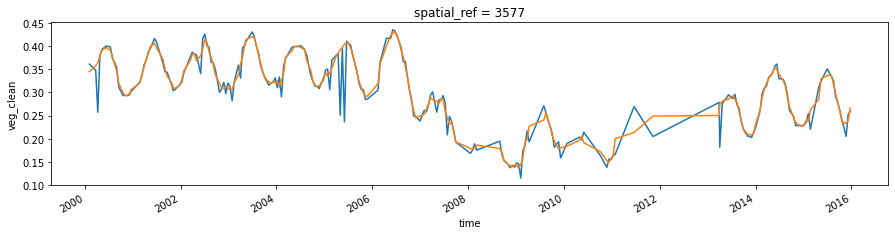

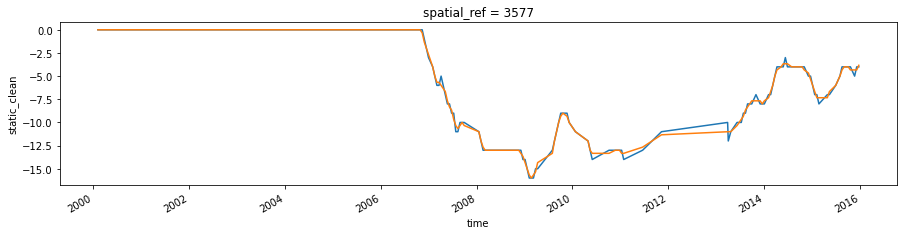

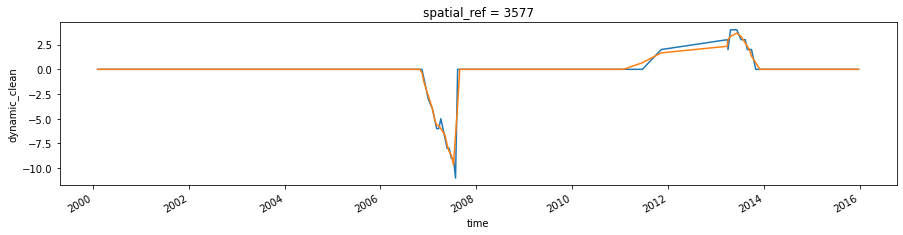

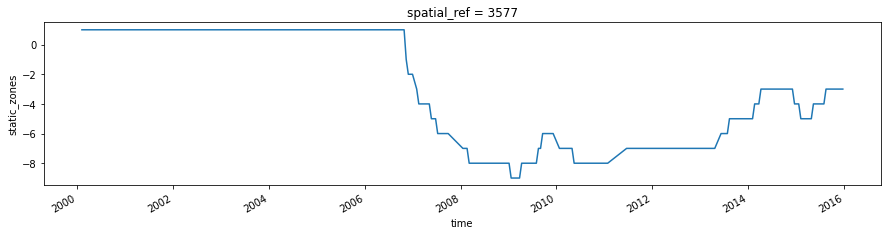

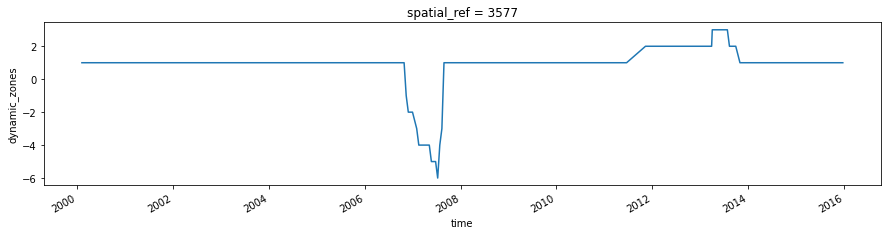

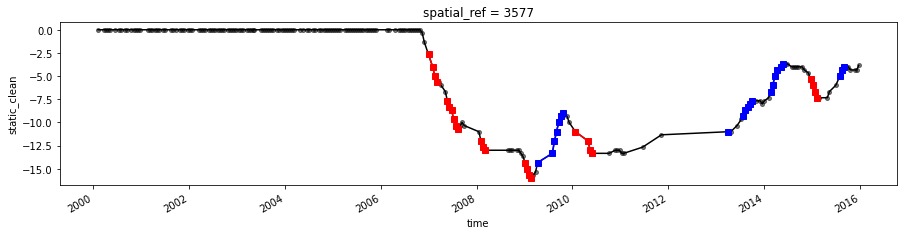

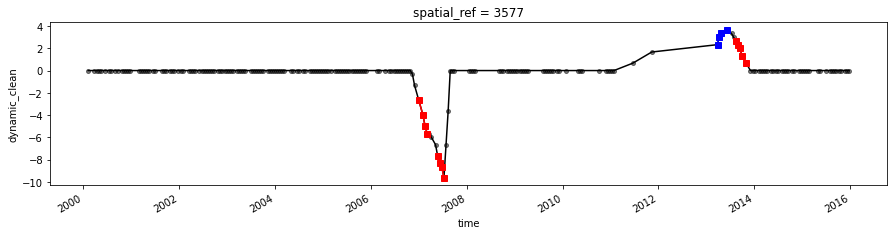

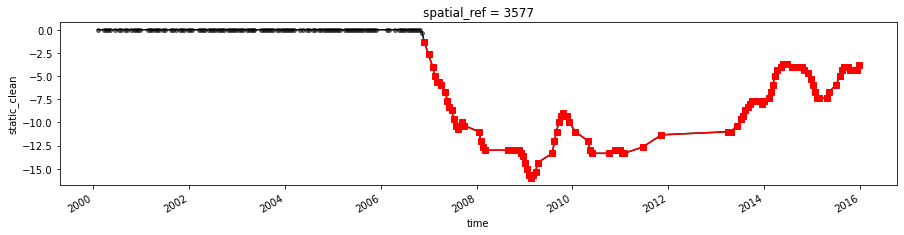

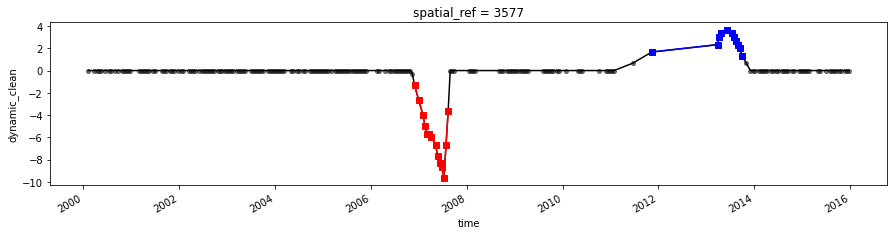

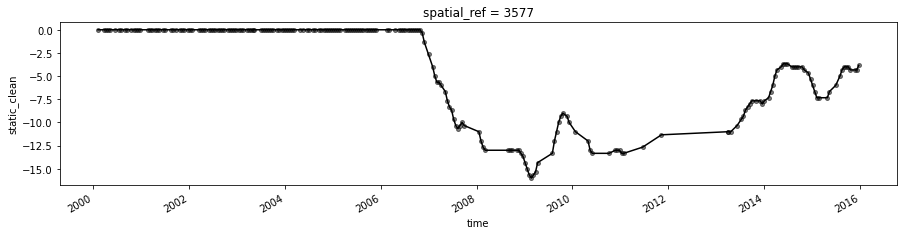

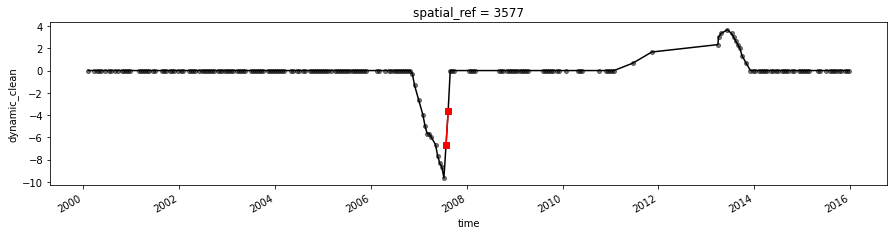

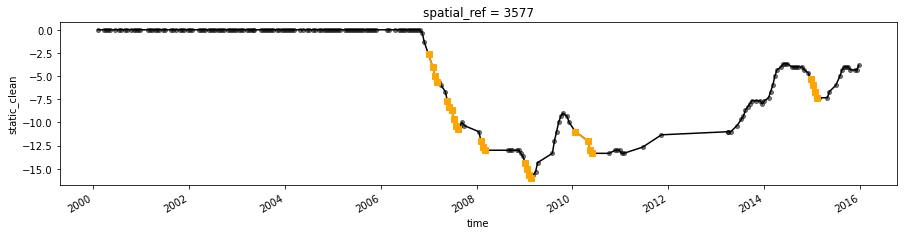

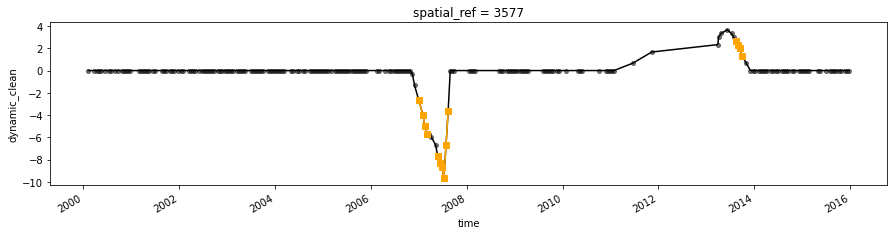

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

if True:
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['veg_idx'].plot()
    ds_tmp['veg_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_raw'].plot()
    ds_tmp['static_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_raw'].plot()
    ds_tmp['dynamic_clean'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_zones'].plot()
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_zones'].plot()
    plt.show()    
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_one'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_two'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['static_clean'].where(ds_tmp['static_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()

    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] > 0).plot(marker='s', color='blue')
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_rule_three'] < 0).plot(marker='s', color='red')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['static_clean'].plot(color='black')
    ds_tmp['static_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['static_clean'].where(ds_tmp['static_alerts'] > 0).plot(marker='s', color='orange')
    plt.show()
    
    fig = plt.figure(figsize=[15, 3])
    ds_tmp['dynamic_clean'].plot(color='black')
    ds_tmp['dynamic_clean'].plot(linestyle='None', markersize=4, marker='o', color='black', alpha=0.5)
    ds_tmp['dynamic_clean'].where(ds_tmp['dynamic_alerts'] > 0).plot(marker='s', color='orange')
    plt.show()

In [ ]:
# # # # #
# notify and increment progess bar
arcpy.SetProgressorLabel('Exporting NetCDF file...')
arcpy.SetProgressorPosition(21)   

try:
    # export netcdf file
    tools.export_xr_as_nc(ds=ds, filename=out_nc)
except Exception as e:
    arcpy.AddError('Could not export dataset.')
    arcpy.AddMessage(str(e))
    return



# # # # #
# notify and increment progress bar
arcpy.SetProgressorLabel('Adding output to map, if requested...')
arcpy.SetProgressorPosition(22)

# if requested...
if in_add_result_to_map:
    try:
        # open current map
        aprx = arcpy.mp.ArcGISProject('CURRENT')
        m = aprx.activeMap

        # remove existing ensemble layers if exist
        for layer in m.listLayers():
            if layer.isGroupLayer and layer.name == 'metrics':
                m.removeLayer(layer)

        # setup a group layer via template
        grp_lyr = arcpy.mp.LayerFile(GRP_LYR_FILE)
        grp = m.addLayer(grp_lyr)[0]
        grp.name = 'metrics'

        # create output folder using datetime as name
        dt = datetime.datetime.now().strftime('%d%m%Y%H%M%S')
        out_folder = os.path.join(os.path.dirname(out_nc), 'metrics' + '_' + dt)
        os.makedirs(out_folder)

        # disable visualise on map temporarily
        arcpy.env.addOutputsToMap = False

        # iter each var and export a seperate tif
        tif_list = []
        for var in ds:

            # create temp netcdf for one var (prevents 2.9 bug)
            with tempfile.NamedTemporaryFile() as tmp:
                tmp_nc = '{}_{}.nc'.format(tmp.name, var)
                ds[[var]].to_netcdf(tmp_nc)

            # build in-memory crf for temp netcdf
            crf = arcpy.md.MakeMultidimensionalRasterLayer(in_multidimensional_raster=tmp_nc, 
                                                           out_multidimensional_raster_layer=var)

            # export temp tif
            tmp_tif = os.path.join(out_folder, '{}.tif'.format(var))
            tif = arcpy.management.CopyRaster(in_raster=crf, 
                                              out_rasterdataset=tmp_tif)

            # add temp tif to map and get as layer
            m.addDataFromPath(tif)
            layer = m.listLayers('{}.tif'.format(var))[0]

            # hide layer once added
            #layer.visible = False

            # add layer to group and then remove outside layer
            m.addLayerToGroup(grp, layer, 'BOTTOM')
            m.removeLayer(layer) 

            # success, add store current layer for symbology below
            tif_list.append('{}.tif'.format(var))

    except Exception as e:
        arcpy.AddWarning('Could not visualise output, aborting visualisation.')
        arcpy.AddMessage(str(e))
        pass

    try:       
        # iter tif layer names and update symbology
        for tif in tif_list:
            layer = m.listLayers(tif)[0]
            sym = layer.symbology                    

            # if layer has stretch coloriser, apply color
            if hasattr(sym, 'colorizer'):
                if sym.colorizer.type == 'RasterStretchColorizer':

                    # apply percent clip type
                    sym.colorizer.stretchType = 'PercentClip'

                    # colorize depending on metric 
                    if 'roi' in tif or 'rod' in tif:
                        sym.colorizer.minPercent = 1.0
                        sym.colorizer.maxPercent = 1.0
                        cmap = aprx.listColorRamps('Inferno')[0]                                                           
                    elif 'aos' in tif or 'los' in tif:
                        sym.colorizer.minPercent = 0.5
                        sym.colorizer.maxPercent = 0.5
                        cmap = aprx.listColorRamps('Spectrum By Wavelength-Full Bright')[0]  
                    elif 'nos' in tif:
                        sym.colorizer.stretchType = 'MinimumMaximum'
                        cmap = aprx.listColorRamps('Spectrum By Wavelength-Full Bright')[0]  
                    elif 'times' in tif:
                        sym.colorizer.minPercent = 0.25
                        sym.colorizer.maxPercent = 0.25
                        cmap = aprx.listColorRamps('Temperature')[0]
                    elif 'values' in tif:
                        sym.colorizer.minPercent = 1.0
                        sym.colorizer.maxPercent = 1.0
                        cmap = aprx.listColorRamps('Precipitation')[0]                                

                    # apply color map
                    sym.colorizer.colorRamp = cmap

                    # apply other basic options
                    sym.colorizer.invertColorRamp = False
                    sym.colorizer.gamma = 1.0

                    # update symbology
                    layer.symbology = sym

                    # show layer 
                    #layer.visible = True

    except Exception as e:
        arcpy.AddWarning('Could not colorise output, aborting colorisation.')
        arcpy.AddMessage(str(e))
        pass

In [393]:
import tempfile



# create temp folder (prevents 2.9 bug)
tmp_dir = tempfile.TemporaryDirectory()

# create temp netcdf for output
tmp_nc = os.path.join(tmp_dir.name, 'cog_explore.nc')
#ds.to_netcdf(tmp_nc)

In [394]:
tmp_nc

'C:\\Users\\Lewis\\AppData\\Local\\Temp\\ArcGISProTemp21244\\tmp7x_26drl\\cog_explore.nc'